## 결과가 Lightgbm과 Scikit-Learn 버전에 따라 달라지니 아래 버전으로 재현해야 합니다
>* LightGBM: 2.3.0
>* Scikit-learn: 0.21.3

In [211]:
import gc
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold, TimeSeriesSplit, GroupKFold, LeaveOneGroupOut, LeavePGroupsOut
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

import datetime
from dateutil.parser import parse
from sklearn.metrics import f1_score
pd.set_option('display.max_rows',500)

import warnings
warnings.filterwarnings("ignore")

In [212]:
def optimal_cut_value(y_true, y_pred, cut_min=0.2, cut_max=0.4, cut_step = 0.01):
    test_cut_list = np.arange(cut_min, cut_max, cut_step)
    result = pd.DataFrame(columns=['cut','score'])
    for cut in tqdm(test_cut_list):
        y_pred_temp = []
        for s in y_pred:
            if s >= cut:
                y_pred_temp.append(1)
            else:
                y_pred_temp.append(0)
    
        score = f1_score(y_true, y_pred_temp)
        result.loc[len(result),['cut','score']] = (cut, score)
    result = result.sort_values('score',ascending=False).reset_index(drop=True)
    print(result.head(1).values)
    return result.head(1).values[0]

In [213]:
def make_time_feature(df):
    df['dt_of_fr'] = pd.to_datetime(df['dt_of_fr'])
    df["year"] = df["dt_of_fr"].dt.year
    df["hour"] = df["dt_of_fr"].dt.hour
    df["weekday"] = df["dt_of_fr"].dt.weekday
    df["month"] = df["dt_of_fr"].dt.month
    df["day"] = df["dt_of_fr"].dt.day
    return df

In [214]:
def update_null_data(data, index_col_list, target_col, agg_func, is_fillna_ffill=False):
    null_count = data[target_col].isnull().sum()
    print("############### FILL NA ###############")
    print(index_col_list, agg_func,'->',target_col)
    print("Original NA Count: ",null_count)
    data = data.set_index(index_col_list)
    if is_fillna_ffill is True:
        _filler = pd.DataFrame(data.groupby(index_col_list)[target_col].agg(agg_func).fillna(method='ffill') ,columns=[target_col])
    else:
        _filler = pd.DataFrame(data.groupby(index_col_list)[target_col].agg(agg_func) ,columns=[target_col])
    data.update(_filler,overwrite=False)
    data = data.reset_index()
    remain_null_count = data[target_col].isnull().sum()
    print("Fill NA Count: ", null_count-remain_null_count)
    print("Remain Null Count: ", remain_null_count)
    return data

In [215]:
train = pd.read_csv('../input/PJT002_train.csv')
test = pd.read_csv('../input/PJT002_test.csv')
validation = pd.read_csv('../input/PJT002_validation.csv')
submission = pd.read_csv('../input/PJT002_submission.csv')

In [216]:
train['fr_yn'] = train['fr_yn'].map({'Y':1,'N':0})
train['dataset'] = 0
validation['fr_yn'] = validation['fr_yn'].map({'Y':1,'N':0})
validation['dataset'] = 1
test['dataset'] = 2

In [217]:
all_data = pd.concat([train,validation, test], ignore_index=True)

In [218]:
lw_feature = [ c for c in all_data.columns if c.find('lw') != -1]
ele_engry_feature = [ c for c in all_data.columns if c.find('ele_engry') != -1]
gas_engry_feature = [ c for c in all_data.columns if c.find('gas') != -1]

train_columns = [c for c in all_data.columns if c not in lw_feature+ele_engry_feature+ele_engry_feature+['dataset','dt_of_fr','fr_yn','id']]
all_data['null_count'] = all_data[train_columns].isnull().sum(axis=1)
    
# dt_of_athrztn, ele_engry_feature, gas_engry_feature
all_data['ele_null_count'] = all_data[ele_engry_feature].isnull().sum(axis=1)
all_data['ele_engry_mean'] = all_data[ele_engry_feature].mean(axis=1)
all_data['ele_engry_sum'] = all_data[ele_engry_feature].sum(axis=1)
all_data['ele_engry_max'] = all_data[ele_engry_feature].max(axis=1)
all_data['gas_engry_mean'] = all_data[gas_engry_feature].mean(axis=1)
all_data['gas_engry_sum'] = all_data[gas_engry_feature].sum(axis=1)
all_data['gas_engry_max'] = all_data[gas_engry_feature].max(axis=1)

# lw_feature
all_data['lw_null_count'] = all_data[lw_feature].isnull().sum(axis=1)
all_data['lw_null_mean'] = all_data[lw_feature].mean(axis=1)
all_data['lw_null_sum'] = all_data[lw_feature].sum(axis=1)

In [219]:
all_data = make_time_feature(all_data) # time feature

In [220]:
# emd nm을 분리한다. 분리할 때 규칙에 안 맞는 것이 많아서 수동으로 규칙을 찾아 분리하는 함수를 만들었다.
def emd_nm_correction(x):
    if pd.isna(x):
        return np.nan
    s_p = x.split(' ')
    v = s_p[1]
    if len(v) >3:
        return s_p[0] + ' ' +v[:3] + ' '+v[3:] + ' '+' '.join(s_p[2:])
    else:
        return x
all_data['emd_nm'] = all_data['emd_nm'].apply(lambda x: emd_nm_correction(x))
all_data.loc[all_data['emd_nm'].isnull(),'emd_nm'] = '- - -'

def get_emd_nm_list(x):
    if pd.isna(x):
        return np.nan
    s_p = x.split(' ')
    return s_p
all_data['emd_nm_list'] = all_data['emd_nm'].apply(lambda x: get_emd_nm_list(x))

temp = pd.DataFrame(all_data['emd_nm_list'].to_list())
temp.columns = [f'emd_nm_{c}'for c in temp.columns]
all_data = pd.concat([all_data,temp],axis=1)
del all_data['emd_nm_list']
del all_data['emd_nm_4']

In [221]:
# 건물, 건축, 토지 면적과 지역을 사용하여 같은 건물을 판단한다.
all_data['same_bld'] = all_data['bldng_ar'].astype(str) +'_' +all_data['ttl_ar'].astype(str)+'_'+all_data['lnd_ar'].astype(str)+'_'+all_data['emd_nm'].astype(str)
all_data.loc[all_data['emd_nm'].isnull(),'same_bld' ] = np.nan
all_data.loc[all_data['bldng_ar']==0,'same_bld' ] = np.nan
all_data['is_null_same_bld'] = 0
all_data.loc[all_data['same_bld'].isnull(),'is_null_same_bld'] = 1
all_data['same_bld_freq_enc'] = all_data['same_bld'].map(all_data['same_bld'].value_counts())
all_data['is_only_one_same_bld'] = 0
all_data.loc[all_data['same_bld_freq_enc']==1, 'is_only_one_same_bld' ] = 1

In [222]:
all_data['each_ttl_ar_price'] = all_data['ttl_ar']/all_data['bldng_ar_prc'] # 건물 면적대비 가격
all_data['each_bldng_ar_price'] = all_data['bldng_ar']/all_data['bldng_ar_prc'] # 건축면적 대비 가격
all_data['each_lnd_ar_price'] = all_data['lnd_ar']/all_data['bldng_ar_prc'] # 토지면적 대비 가격

In [223]:
all_data['is_null_prcpttn'] = all_data['prcpttn'].isnull()
all_data = update_null_data(all_data, ['month','day','hour','emd_nm'], 'prcpttn','mean', is_fillna_ffill=False)
all_data = update_null_data(all_data, ['month','day','emd_nm'], 'prcpttn','mean', is_fillna_ffill=False)
all_data = update_null_data(all_data, ['month','day','emd_nm_2'], 'prcpttn','mean', is_fillna_ffill=False)
all_data = update_null_data(all_data, ['month','day','emd_nm_1'], 'prcpttn','mean', is_fillna_ffill=False)
all_data.loc[all_data['prcpttn'].isnull() ,'prcpttn'] = 0 # 강수량이 na는 없는 것으로?

# 같은 지역 월/날짜로 na값을 채운다.
# na가 feature가 될 수 있기도 한데 일단 나중에 분석해봐야 한다.
all_data = update_null_data(all_data, ['month','day','emd_nm'], 'tmprtr','mean', is_fillna_ffill=True)
all_data = update_null_data(all_data, ['month','day','emd_nm'], 'wnd_spd','mean', is_fillna_ffill=True)
all_data = update_null_data(all_data, ['month','day','emd_nm'], 'hmdt','mean', is_fillna_ffill=True)
all_data = update_null_data(all_data, ['month','day','emd_nm'], 'wnd_drctn','mean', is_fillna_ffill=True)

############### FILL NA ###############
['month', 'day', 'hour', 'emd_nm'] mean -> prcpttn
Original NA Count:  62721
Fill NA Count:  153
Remain Null Count:  62568
############### FILL NA ###############
['month', 'day', 'emd_nm'] mean -> prcpttn
Original NA Count:  62568
Fill NA Count:  3706
Remain Null Count:  58862
############### FILL NA ###############
['month', 'day', 'emd_nm_2'] mean -> prcpttn
Original NA Count:  58862
Fill NA Count:  2152
Remain Null Count:  56710
############### FILL NA ###############
['month', 'day', 'emd_nm_1'] mean -> prcpttn
Original NA Count:  56710
Fill NA Count:  22476
Remain Null Count:  34234
############### FILL NA ###############
['month', 'day', 'emd_nm'] mean -> tmprtr
Original NA Count:  15
Fill NA Count:  15
Remain Null Count:  0
############### FILL NA ###############
['month', 'day', 'emd_nm'] mean -> wnd_spd
Original NA Count:  38
Fill NA Count:  38
Remain Null Count:  0
############### FILL NA ###############
['month', 'day', 'emd_nm'] mean

In [224]:
from meteocalc import Temp, dew_point, heat_index, wind_chill, feels_like

# 불쾌지수
all_data['feels_bad'] = (9/5)*all_data['tmprtr'] - 0.55*(1-all_data['hmdt'])*((9/5)*all_data['tmprtr']-26)+32

all_data['tmprtr_f'] = all_data['tmprtr'].apply(lambda x: Temp(x,'c').f)
# meteocalc package를 사용하여 체감온도 계산, 체감온도 계산할 때 화씨 단위로 해야해서 변환 후 계산
all_data['feels_like'] = all_data[['tmprtr_f','hmdt','wnd_spd']].apply(lambda x: feels_like(x['tmprtr_f'],x['hmdt'],x['wnd_spd']),axis=1)
# heat index 계산
all_data['heat_index'] = all_data[['tmprtr_f','hmdt']].apply(lambda x: heat_index(x['tmprtr_f'],x['hmdt']),axis=1)

del all_data['tmprtr_f']
all_data['feels_like'] = all_data['feels_like'].astype(float)
all_data['heat_index'] = all_data['heat_index'].astype(float)

In [225]:
all_data['fr_mn_cnt_null'] = all_data['fr_mn_cnt'].isnull()
all_data = update_null_data(all_data, ['emd_nm'], 'fr_mn_cnt','mean', is_fillna_ffill=False)
all_data = update_null_data(all_data, ['emd_nm_2'], 'fr_mn_cnt','mean', is_fillna_ffill=False)
all_data = update_null_data(all_data, ['emd_nm_1'], 'fr_mn_cnt','mean', is_fillna_ffill=False)

############### FILL NA ###############
['emd_nm'] mean -> fr_mn_cnt
Original NA Count:  42
Fill NA Count:  40
Remain Null Count:  2
############### FILL NA ###############
['emd_nm_2'] mean -> fr_mn_cnt
Original NA Count:  2
Fill NA Count:  1
Remain Null Count:  1
############### FILL NA ###############
['emd_nm_1'] mean -> fr_mn_cnt
Original NA Count:  1
Fill NA Count:  1
Remain Null Count:  0


In [226]:
# 같은 지역이더라도 연도별 인구수가 다르기 때문에, 같은 빌딩에 같은 년도로 먼저 채우고
# 지역, 연도 -> 지역, 세부지역 -> 큰 지역 순으로 NULL값을 채워나간다.
all_data['hm_cnt_null'] = all_data['hm_cnt'].isnull()
all_data = update_null_data(all_data, ['same_bld','year'], 'hm_cnt','mean')
all_data = update_null_data(all_data, ['emd_nm','year','month'], 'hm_cnt','mean') # emd_nm
all_data = update_null_data(all_data, ['emd_nm','year'], 'hm_cnt','mean') # emd_nm
all_data = update_null_data(all_data, ['emd_nm'], 'hm_cnt','mean')
all_data = update_null_data(all_data, ['emd_nm_2','year','month'], 'hm_cnt','mean') # emd_nm2
all_data = update_null_data(all_data, ['emd_nm_2','year'], 'hm_cnt','mean') # emd_nm2
all_data = update_null_data(all_data, ['emd_nm_2'], 'hm_cnt','mean')
all_data = update_null_data(all_data, ['emd_nm_1','year','month'], 'hm_cnt','mean') # emd_nm1
all_data = update_null_data(all_data, ['emd_nm_1','year'], 'hm_cnt','mean') # emd_nm1
all_data = update_null_data(all_data, ['emd_nm_1'], 'hm_cnt','mean')

############### FILL NA ###############
['same_bld', 'year'] mean -> hm_cnt
Original NA Count:  702
Fill NA Count:  0
Remain Null Count:  702
############### FILL NA ###############
['emd_nm', 'year', 'month'] mean -> hm_cnt
Original NA Count:  702
Fill NA Count:  11
Remain Null Count:  691
############### FILL NA ###############
['emd_nm', 'year'] mean -> hm_cnt
Original NA Count:  691
Fill NA Count:  11
Remain Null Count:  680
############### FILL NA ###############
['emd_nm'] mean -> hm_cnt
Original NA Count:  680
Fill NA Count:  492
Remain Null Count:  188
############### FILL NA ###############
['emd_nm_2', 'year', 'month'] mean -> hm_cnt
Original NA Count:  188
Fill NA Count:  119
Remain Null Count:  69
############### FILL NA ###############
['emd_nm_2', 'year'] mean -> hm_cnt
Original NA Count:  69
Fill NA Count:  1
Remain Null Count:  68
############### FILL NA ###############
['emd_nm_2'] mean -> hm_cnt
Original NA Count:  68
Fill NA Count:  59
Remain Null Count:  9
#########

In [227]:
all_data.loc[(all_data['bldng_us']=='위험물저장및처리시설')&(all_data['lnd_us_sttn_nm']!='공업용'),'bldng_us_clssfctn'] = '상업용'
all_data.loc[(all_data['bldng_us']=='위험물저장및처리시설')&(all_data['lnd_us_sttn_nm']=='공업용'),'bldng_us_clssfctn'] = '공업용'

In [228]:
# 건물 승인일자
all_data.loc[all_data['dt_of_athrztn'].notnull(),'dt_of_athrztn'] = all_data.loc[all_data['dt_of_athrztn'].notnull(),'dt_of_athrztn'].astype(str)
def get_len(x):
    if pd.isna(x):
        return 0
    return len(x)
all_data['dt_of_athrztn_len'] = all_data['dt_of_athrztn'].apply(lambda x: get_len(x))
# 수동으로 데이터 보면서 처리한 이상한 건물 승인일자 9개, 앞단에서 sort되면 이 값이 틀어지기 때문에 조심해야한다.
all_data.loc[all_data['dt_of_athrztn_len']==9,'dt_of_athrztn'] = ['1989','1890','1890','1990','1999','1982','1978','1994']
del all_data['dt_of_athrztn_len']

def conv_date(x):
    if pd.isna(x):
        return np.nan
    
    if isinstance(x, str) is False:
        print(x, 'not str')
        return np.nan

    x = x.split('.')[0]
    if len(x) != 8:
        return datetime.datetime.strptime(x[:4], "%Y") # year
    try:
        m = int(x[4:6])
        d = int(x[6:8])
        if 0 < m < 13 and 0 < d < 32: # month와 day가 invalid하면 year, month, day 사용
            return datetime.datetime.strptime(x, "%Y%m%d") # year month day
        
        if 0 < m < 13: # month가 invalid 하면 month까지
            return datetime.datetime.strptime(x[:6], "%Y%m") # year month day
        else:
            raise ValueError
    except ValueError as e: # 나머지는 year만
        return datetime.datetime.strptime(x[:4], "%Y") # year
        
all_data['dt_of_athrztn'] = all_data['dt_of_athrztn'].apply(lambda x: conv_date(x))

def get_year(x):
    if pd.isna(x):
        return np.nan
    return x.year
all_data['dt_of_athrztn_year'] = all_data['dt_of_athrztn'].apply(lambda x: get_year(x))

In [229]:
def get_diff_dt_of_fr(row):
    if pd.isna(row['dt_of_athrztn']):
        return np.nan
    try:
        return (row['dt_of_fr'] - pd.to_datetime(row['dt_of_athrztn'])).days
    except:
        return np.nan
    
all_data['diff_dt_of_fr'] = all_data[['dt_of_fr','dt_of_athrztn']].apply(lambda row:get_diff_dt_of_fr(row) ,axis=1)
all_data['diff_dt_of_fr_freq_enc'] = all_data['diff_dt_of_fr'].map(all_data['diff_dt_of_fr'].value_counts())

In [230]:
cat_feature = []
for c in all_data.columns:
    if all_data[c].dtypes == 'object':
        print(c)
        cat_feature.append(c)
        all_data[c] = pd.factorize(all_data[c],sort=True)[0]

emd_nm_1
emd_nm_2
emd_nm
same_bld
bldng_archtctr
bldng_us
bldng_us_clssfctn
blk_dngrs_thng_mnfctr_yn
cltrl_hrtg_yn
dngrs_thng_yn
dt_of_athrztn
fr_fghtng_fclt_spcl_css_5_yn
fr_fghtng_fclt_spcl_css_6_yn
jmk
lnd_us_sttn_nm
mlt_us_yn
rd_sd_nm
rgnl_ar_nm
rgnl_ar_nm2
slf_fr_brgd_yn
trgt_crtr
us_yn
emd_nm_0
emd_nm_3


In [241]:
train = all_data.loc[all_data['dataset'].isin([0,1])] # train + validation
print(train.shape)
train = train.loc[~train['emd_nm_1'].isin([0,13])] # 창원시는 불이 안났는데?? 아마 잘못 샘플링 된 것 같으니 빼버린다.
print(train.shape)
validation = all_data.loc[all_data['dataset']==1].reset_index(drop=True)
test = all_data.loc[all_data['dataset']==2].reset_index(drop=True)

(66097, 217)
(57651, 217)


In [244]:
train_columns = [c for c in train.columns if c not in lw_feature+ele_engry_feature+gas_engry_feature+['dataset','dt_of_fr','fr_yn',
                                                                                                      'id',
                                                                                                   'emd_nm_0','emd_nm_3',
                                                                                                      'is_null_same_bld']]
cat_feature = ['same_bld', 'bldng_archtctr','bldng_us','bldng_us_clssfctn',
               'jmk','lnd_us_sttn_nm','rd_sd_nm','rgnl_ar_nm','rgnl_ar_nm2','trgt_crtr','emd_nm']

lgb_param = {'boost': 'gbdt', 
         'feature_fraction': 0.3, 
         'bagging_fraction': 0.8, 
         'learning_rate': 0.05, 
         'subsample_freq': 1,
         'max_depth': -1,
         'metric': 'auc', 
         'num_leaves': 256, 
         'num_threads': 32, 
         'objective': 'binary', 
         'verbosity': 1, 
         'seed': 46}

print(lgb_param)
print(train_columns)

oof_train = np.zeros(len(train))
oof_test = np.zeros(len(test))

x_train = train.copy()
y_train = x_train['fr_yn']

NFOLD = 5
SEED = 42

feature_importance_df = pd.DataFrame()
total_cv_score = 0
holdout_cv_score = 0
holdout_total_cv_score = 0

kfold = StratifiedKFold(n_splits=NFOLD, shuffle=True, random_state=SEED)
for i, (train_index, cross_index) in enumerate(kfold.split(x_train,y_train),1):
    print(f"{i} FOLD Start")
    x_tr = x_train.iloc[train_index]
    x_cr = x_train.iloc[cross_index]
    y_tr = y_train.iloc[train_index]
    y_cr = y_train.iloc[cross_index]

    x_tr = x_tr[train_columns]
    x_cr = x_cr[train_columns]

    dtrain = lgb.Dataset(x_tr, label=y_tr, silent=True)
    dcross = lgb.Dataset(x_cr, label=y_cr, silent=True)

    clf = lgb.train(lgb_param, train_set=dtrain, num_boost_round=10000, valid_sets=[dtrain, dcross], 
                    early_stopping_rounds=100, verbose_eval=100, categorical_feature=cat_feature)

    oof_train[cross_index] = clf.predict(x_cr)
    oof_test += clf.predict(test[train_columns]) / NFOLD

    feature_importance = pd.DataFrame()
    feature_importance["Feature"] = x_tr.columns
    feature_importance["Importance"] = clf.feature_importance()
    feature_importance["FOLD"] = i
    feature_importance_df = pd.concat([feature_importance_df, feature_importance])

    cv_score = roc_auc_score(y_cr, oof_train[cross_index])
    print("Train Optimal F1-Score")
    tr_result = optimal_cut_value(y_cr, oof_train[cross_index])

    total_cv_score += cv_score / NFOLD
    
    print(f"{i} FOLD Score: ", cv_score)

print("Total CV: ", total_cv_score, holdout_total_cv_score)
print("Total CV2: ", roc_auc_score(y_train, oof_train))

tr_result = optimal_cut_value(y_train, oof_train,cut_step=0.01)

{'boost': 'gbdt', 'feature_fraction': 0.3, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'subsample_freq': 1, 'max_depth': -1, 'metric': 'auc', 'num_leaves': 256, 'num_threads': 32, 'objective': 'binary', 'verbosity': 1, 'seed': 46}
['emd_nm_1', 'year', 'month', 'emd_nm_2', 'emd_nm', 'same_bld', 'day', 'hour', 'ahsm_dstnc', 'bldng_ar', 'bldng_ar_prc', 'bldng_archtctr', 'bldng_cnt', 'bldng_cnt_in_50m', 'bldng_us', 'bldng_us_clssfctn', 'blk_dngrs_thng_mnfctr_yn', 'cctv_dstnc', 'cctv_in_100m', 'cltrl_hrtg_yn', 'dngrs_thng_yn', 'dt_of_athrztn', 'fr_fghtng_fclt_spcl_css_5_yn', 'fr_fghtng_fclt_spcl_css_6_yn', 'fr_mn_cnt', 'fr_sttn_dstnc', 'fr_wthr_fclt_dstnc', 'fr_wthr_fclt_in_100m', 'hm_cnt', 'hmdt', 'jmk', 'lnd_ar', 'lnd_us_sttn_nm', 'mlt_us_yn', 'no_tbc_zn_dstnc', 'prcpttn', 'rd_sd_nm', 'rgnl_ar_nm', 'rgnl_ar_nm2', 'sft_emrgnc_bll_dstnc', 'slf_fr_brgd_yn', 'tbc_rtl_str_dstnc', 'tmprtr', 'trgt_crtr', 'ttl_ar', 'ttl_dwn_flr', 'ttl_grnd_flr', 'us_yn', 'wnd_drctn', 'wnd_spd', 'null_count', 

[[0.2800000000000001 0.5581874356333677]]
1 FOLD Score:  0.8827854982915406
2 FOLD Start
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.995217	valid_1's auc: 0.884272
Early stopping, best iteration is:
[94]	training's auc: 0.994103	valid_1's auc: 0.884552
Train Optimal F1-Score


[[0.26000000000000006 0.5526954832442934]]
2 FOLD Score:  0.8845518734447332
3 FOLD Start
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.995176	valid_1's auc: 0.885551
Early stopping, best iteration is:
[47]	training's auc: 0.97633	valid_1's auc: 0.886592
Train Optimal F1-Score


[[0.26000000000000006 0.5637122514117359]]
3 FOLD Score:  0.886591510160837
4 FOLD Start
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.995232	valid_1's auc: 0.882645
Early stopping, best iteration is:
[84]	training's auc: 0.991939	valid_1's auc: 0.883982
Train Optimal F1-Score


[[0.24000000000000005 0.5480410447761194]]
4 FOLD Score:  0.8839818686095128
5 FOLD Start
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.994947	valid_1's auc: 0.887812
Early stopping, best iteration is:
[43]	training's auc: 0.974039	valid_1's auc: 0.889012
Train Optimal F1-Score


[[0.2800000000000001 0.5732250458475242]]
5 FOLD Score:  0.8890123290695588
Total CV:  0.8853846159152364 0
Total CV2:  0.884776566262193


[[0.2800000000000001 0.557575131674068]]


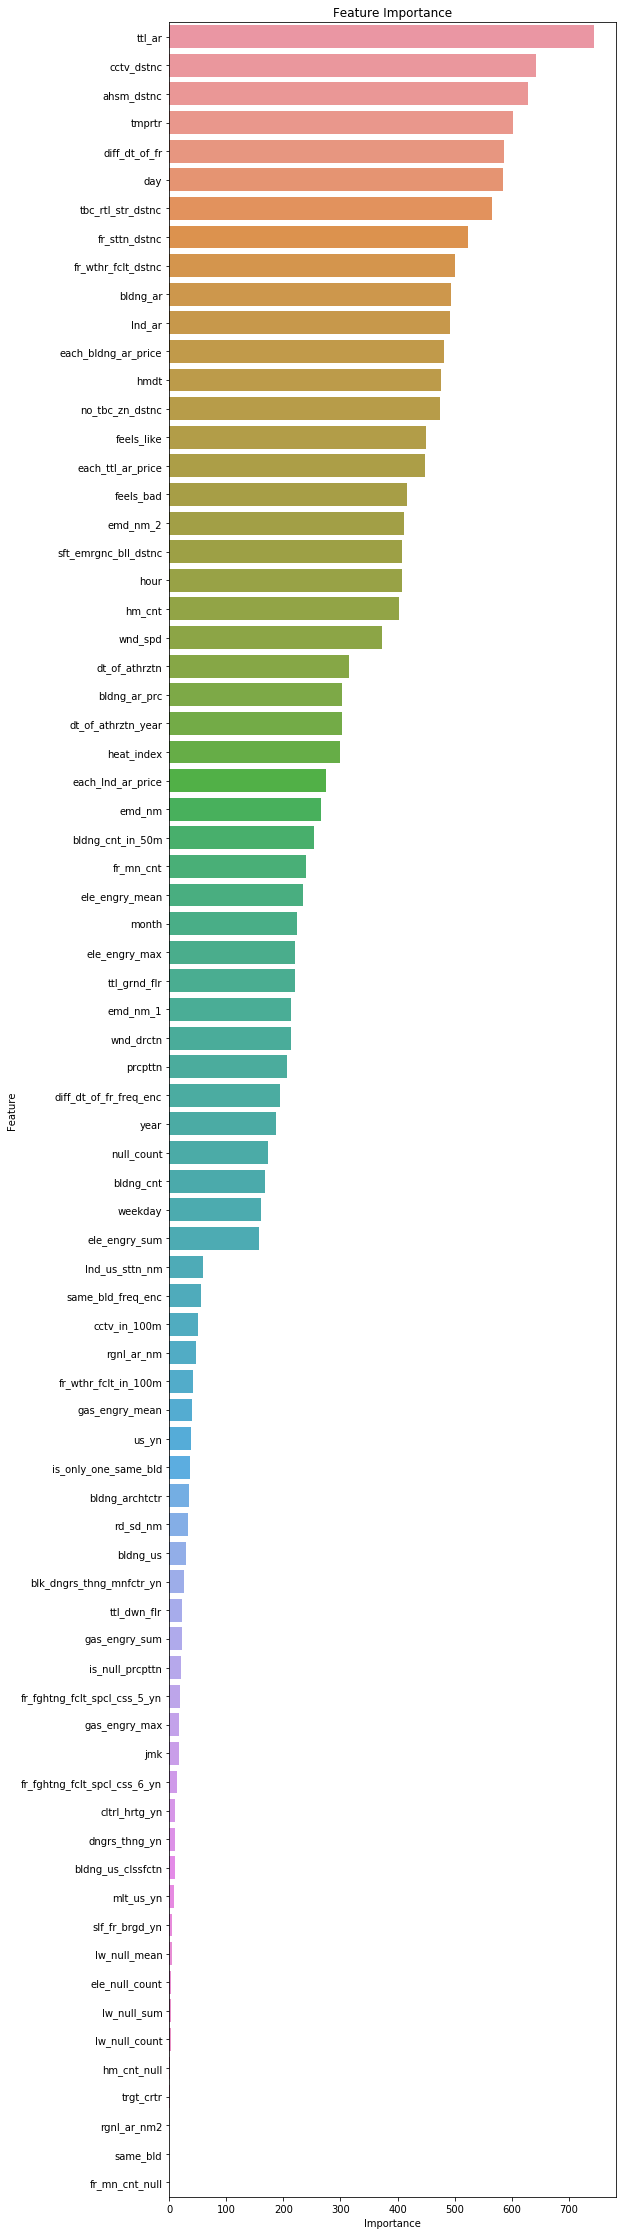

In [233]:
fi_result = feature_importance_df.groupby(['Feature'])['Importance'].mean().reset_index()
temp = fi_result.sort_values('Importance',ascending=False)
plt.figure(figsize=(8,40))
sns.barplot('Importance','Feature',data=temp,orient='h')
plt.title('Feature Importance')
plt.show()

## 컷오프에 따른 점수 확인. 
- 0.32 0.53506 
- 0.2965 0.56491
- **0.2975 0.56591** 
- 0.2945 0.56491 
- 0.2935 0.56392 
- 0.291 0.56195 
- power, 2 0.09 0.56338 
- power 2 0.091 0.56437 

In [234]:
cut_off = 0.2975
oof_conv = []
for c in oof_test:
    if c >= cut_off:
        oof_conv.append('Y')
    else:
        oof_conv.append('N')
        
print(cut_off, len([c for c in oof_conv if c=='Y']))

0.2975 542


## Post Processing
- jmk_comb4는 dt_of_athrztn가 not null인 row에서 category 변수를 4 combination으로 조합한 것.<br>
- data를 보면 zero_ratio가 1인 것들이 많다.  <br>
- 모델의 오버피팅을 방지하기 위해서 zero_count가 50개 초과이면서 zero_ratio가 0.95 초과인 것들은 0으로 바꿔준다. <br>
- 0.95, 50을 선택한 이유는 cut_off 0.2975에서 모델이 

In [235]:
comb4 = pd.read_csv('../input/jmk_comb4.csv',encoding='euc-kr')
temp = comb4.loc[comb4['zero_count']>50].sort_values(['zero_ratio','zero_count'],ascending=[False,False])
temp = temp.loc[(temp['zero_ratio']>0.95)]
test = pd.read_csv('../input/PJT002_test.csv')
temp['test_count'] = 0
temp['id'] = np.nan
acc_count = 0
for i, row in tqdm(temp.iterrows()):
    cat0 = row['cat0']
    cat1 = row['cat1']
    cat2 = row['cat2']
    cat3 = row['cat3']
    c0u = row['c0u']
    c1u = row['c1u']
    c2u = row['c2u']
    c3u = row['c3u']
    selected = test.loc[(test[cat0]==c0u)&(test[cat1]==c1u)&(test[cat2]==c2u)&(test[cat3]==c3u)]
    count = selected.shape[0]
    acc_count += count
    if count > 0:
        print(count, acc_count, row['zero_ratio'])
    if count == 0:
        temp.loc[i,('test_count','id')] = (count,np.nan)
    else:
        temp.loc[i,('test_count','id')] = (count,set(selected['id'].values))

1 1 1.0
1 2 1.0
1 3 1.0
1 4 1.0
1 5 1.0
1 6 1.0
1 7 1.0
1 8 1.0
1 9 0.9938650306748468
1 10 0.99375
1 11 0.9927007299270072
1 12 0.9927007299270072
1 13 0.9926470588235294
1 14 0.984126984126984
1 15 0.9835164835164836
1 16 0.9827586206896552
2 18 0.9807692307692308
2 20 0.975609756097561
3 23 0.9743589743589745
1 24 0.9718309859154929
2 26 0.9710144927536232
2 28 0.9705882352941176
2 30 0.967741935483871
3 33 0.9666666666666668
13 46 0.9666666666666668
10 56 0.9649122807017544
3 59 0.9562043795620438
7 66 0.9550561797752808
7 73 0.9516129032258064
6 79 0.9503105590062112


In [236]:
all_id_set = set()
for c in temp.loc[(temp['test_count']!=0),'id'].values:
    all_id_set = all_id_set.union(c)

## Post Processing에 의해서 바뀐 결과 확인 
- zero_count > 50
- zero_ratio > 0.95 
- pred 값이 Y

In [237]:
test = pd.read_csv('../input/PJT002_test.csv')
test['pred'] = oof_test
test.loc[(test['id'].isin(all_id_set))&(test['pred']>0.2975),'pred']

457     0.319221
2545    0.353961
Name: pred, dtype: float64

## 리더보드를 통한 점수 확인 
- 실제 알고리즘이 어떻게 분류했는지 살펴본다.<br>
- cut line을 0.32, 0.36으로 바꿔가면서 리더보드 결과를 살펴본다. <br>
- 리더보드 점수가 나빠지지 않았기 때문에 사용.<br>

In [238]:
submission = pd.read_csv('../input/PJT002_submission.csv')
submission['fr_yn'] = oof_test
submission['fr_yn_real'] = np.nan

# 여러 번 제출하여 cut off 값을 정함

submission.loc[(test.loc[test['id'].isin(all_id_set)].index)&(submission.loc[submission['fr_yn']<0.36].index),'fr_yn_real'] = 'N'
submission.loc[(submission['fr_yn']>=0.2975)&(submission['fr_yn_real'].isnull()),'fr_yn_real'] = 'Y'
submission.loc[(submission['fr_yn']<0.2975)&(submission['fr_yn_real'].isnull()),'fr_yn_real'] = 'N'
del submission['fr_yn']
submission.columns = ['fr_yn']
len([c for c in submission['fr_yn'] if c=='Y'])

540

In [239]:
submission['fr_yn'] = oof_conv
submission.to_csv('../output/yeonmin_화재예측과제_Submission.csv',index=False)

# Make Category 4 Combination

In [207]:
train = pd.read_csv('../input/PJT002_train.csv')
validation = pd.read_csv('../input/PJT002_validation.csv')
all_data = pd.concat([train,validation], ignore_index=True)
dt_of_athrztn_notnull = all_data.loc[all_data['dt_of_athrztn'].notnull()]

cat_feature = ['bldng_archtctr','bldng_us','bldng_us_clssfctn',
               'jmk','lnd_us_sttn_nm','rd_sd_nm','rgnl_ar_nm','rgnl_ar_nm2','trgt_crtr']

In [208]:
unique_list_dict = {}
for c in cat_feature:
    unique_list_dict[c] = dt_of_athrztn_notnull[c].unique()

In [ ]:
import itertools
result_jmk3 = pd.DataFrame(columns=['cat0','cat1','cat2','cat3','c0u','c1u','c2u','c3u','zero_count','one_count','zero_ratio','one_ratio'])
cat_comb = list(itertools.combinations(cat_feature, 4))
for c in tqdm(cat_comb):
    cat1 = c[0]
    cat2 = c[1]
    cat3 = c[2]
    cat4 = c[3]
    print(c)
    for c1 in unique_list_dict[cat1]:
        temp = dt_of_athrztn_notnull.loc[dt_of_athrztn_notnull[cat1]==c1]
        if temp.shape[0] == 0:
            continue
        for c2 in unique_list_dict[cat2]:
            temp2 = temp.loc[temp[cat2]==c2]
            if temp2.shape[0] == 0:
                continue
            for c3 in unique_list_dict[cat3]:
                temp3 = temp2.loc[temp2[cat3]==c3]
                if temp3.shape[0] == 0:
                    continue
                for c4 in unique_list_dict[cat4]:
                    temp4 = temp3.loc[(temp3[cat4]==c4),'fr_yn']
                    if temp4.shape[0] == 0:
                        continue
                    item1 = temp4.value_counts()
                    try:
                        z = item1[0]
                    except (KeyError and IndexError):
                        z = 0
                    try:
                        o = item1[1]
                    except (KeyError and IndexError):
                        o = 0
                    result_jmk3.loc[len(result_jmk3),['cat0','cat1','cat2','cat3',
                                                      'c0u','c1u','c2u','c3u',
                                                      'zero_count','one_count','zero_ratio','one_ratio']] = (cat1,cat2,cat3,cat4,
                                                                                                             c1,c2,c3,c4,
                                                                                                                           z,o,
                                                                                                                           z/(z+o),
                                                                                                                           o/(z+o))

In [ ]:
result_jmk3.to_csv('../input/jmk_comb4.csv',index=False,encoding='euc-kr')